In [21]:
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
import pandas as pd

In [22]:
class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.hidden_layer = nn.Linear(3, 100)
        self.output_layer = nn.Linear(100, 3)
        self.activation_function = nn.Tanh()

    def forward(self, x):
        x = self.activation_function(self.hidden_layer(x))
        x = self.output_layer(x)
        return x


def training_loop(training_dataloader, model, optimizer, mse):
    # accumulated the loss
    acc_loss = 0

    for i, (inputs, targets) in enumerate(training_dataloader): 
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = mse(outputs, targets)
        loss.backward()

        # adjust learning weights
        optimizer.step()

        acc_loss += loss.item()
        print(f'  batch {i + 1} loss: {loss.item()}')
        
    avg_loss = acc_loss / len(training_dataloader)
    print(f'  average loss (training): {avg_loss}')

    return avg_loss

def test_loop(testing_dataloader, model, mse):
    model.eval()
    
    acc_loss = 0

    for i, (inputs, targets) in enumerate(testing_dataloader):
        outputs = model(inputs)

        loss = mse(outputs, targets)
        acc_loss += loss.item()

    avg_loss = acc_loss / len(testing_dataloader)
    print(f'  average loss (testing): {avg_loss}')

    model.train()

    return avg_loss


In [23]:
model = MLPModel()

#-------------------------------------------
# Loading the data using pandas
#-------------------------------------------
path = '../../datasets/joint_positions_data_1000.csv'
df = pd.read_csv(path)
X = df[['x', 'y', 'pitch']].to_numpy()
y = df[['shoulder', 'elbow', 'wrist']].to_numpy()

# ----------------------------------------------------------
# splitting the data into training, validation and test sets
# ----------------------------------------------------------
test_size = 0.3
batch_size = 32

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=42
)

# transforming data into tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test,  dtype=torch.float32)

training_dataset = TensorDataset(X_train_tensor, y_train_tensor)
testing_dataset = TensorDataset(X_test_tensor, y_test_tensor)

training_dataloader = DataLoader(
    training_dataset,
    batch_size=batch_size,
    shuffle=True
)
testing_dataloader = DataLoader(
    testing_dataset,
    batch_size=batch_size,
    shuffle=True
)


mse = nn.MSELoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0001
)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50

avg_training_losses = []
avg_testing_losses = []

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}')
    model.train(True)
    avg_loss = training_loop(
        training_dataloader,
        model,
        optimizer,
        mse
    )
    avg_training_losses.append(avg_loss)
    avg_testing_loss = test_loop(
        testing_dataloader,
        model,
        mse
    )
    avg_testing_losses.append(avg_testing_loss)

Epoch: 1
  batch 1 loss: 1.4196977615356445
  batch 2 loss: 1.1909384727478027
  batch 3 loss: 1.2632933855056763
  batch 4 loss: 1.2922731637954712
  batch 5 loss: 1.0938506126403809
  batch 6 loss: 1.2918974161148071
  batch 7 loss: 1.5723379850387573
  batch 8 loss: 1.3349703550338745
  batch 9 loss: 1.2021071910858154
  batch 10 loss: 1.1717430353164673
  batch 11 loss: 1.0927478075027466
  batch 12 loss: 1.4719702005386353
  batch 13 loss: 1.2752718925476074
  batch 14 loss: 1.1848398447036743
  batch 15 loss: 1.2419614791870117
  batch 16 loss: 1.3317204713821411
  batch 17 loss: 1.1507569551467896
  batch 18 loss: 1.2302676439285278
  batch 19 loss: 1.2891523838043213
  batch 20 loss: 1.102150559425354
  batch 21 loss: 1.3226501941680908
  batch 22 loss: 1.3979346752166748
  average loss (training): 1.2692969766530124
  average loss (testing): 1.3486640810966493
Epoch: 2
  batch 1 loss: 1.3188793659210205
  batch 2 loss: 1.0675275325775146
  batch 3 loss: 1.24089777469635
  batc

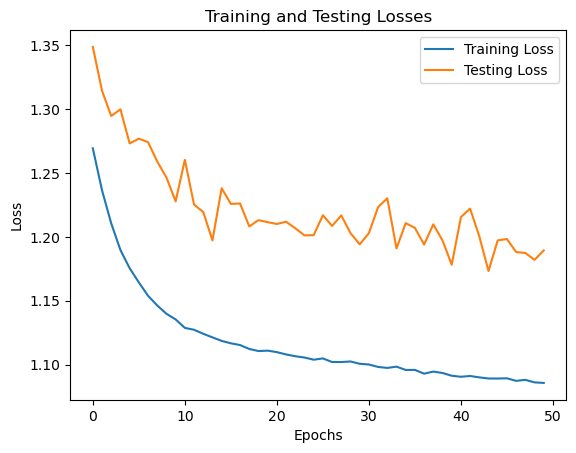

In [24]:
# Plotting the training and testing losses over epochs
import matplotlib.pyplot as plt
plt.plot(avg_training_losses, label='Training Loss')
plt.plot(avg_testing_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

# Saving the model
torch.save(model.state_dict(), '../models/fnn_100.pth')